<a href="https://colab.research.google.com/github/sikandarmir/Skin-Anomaly-Detection/blob/main/CNN_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS=3
EPOCHS=50
dataset=tf.keras.preprocessing.image_dataset_from_directory(
"/content/drive/MyDrive/Data/Train/",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 4726 files belonging to 2 classes.


In [ ]:
class_names=dataset.class_names
class_names

['Melanoma', 'Non_Melanoma']

In [ ]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[1 0 1 1 0 0 0 0 0 0 1 0 1 1 1 1 0 1 0 0 1 1 0 1 1 0 0 0 0 0 0 0]


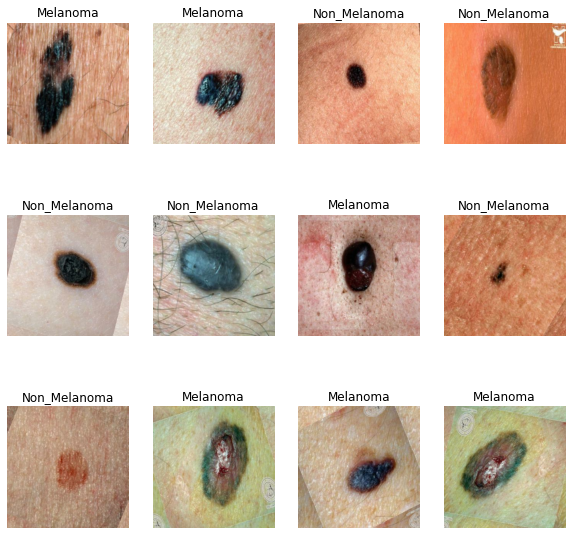

In [ ]:
 plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [ ]:
len(dataset)

148

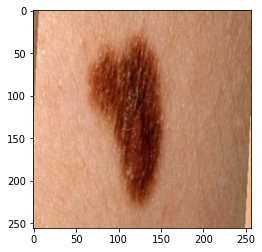

In [ ]:
plt.imshow(image_batch[0].numpy().astype('uint8'))

In [ ]:

len(dataset)
595

NameError: ignored

In [ ]:
train_size=0.8
len(dataset)*train_size
#118

118.4

In [ ]:
train_ds=dataset.take(118)
len(train_ds)
#118

118

In [ ]:
test_ds=dataset.skip(118)
len(test_ds)
#30

30

In [ ]:
val_size=0.1
len(dataset)*val_size
#14

14.8

In [ ]:
val_ds=test_ds.take(14)
len(val_ds)
#14


14

In [ ]:
test_ds=test_ds.skip(14)
len(test_ds)

16

In [ ]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [ ]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [ ]:
len(train_ds)

118

In [ ]:
len(val_ds)


14

In [ ]:
len(test_ds)

16

In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [ ]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])



# train_image_generator = ImageDataGenerator(
#     rescale = 1./255,
#     rotation_range = 45,
#     width_shift_range = .15,
#     height_shift_range = .15,
#     zoom_range = 0.5,
#     horizontal_flip = True,
#     vertical_flip = False
# )
# val_data_gen = train_image_generator.flow_from_directory(
#     batch_size = 3,
#     directory = "D:/Data/FYP/Skin_data_set/Dataset/Train_data/",
#     target_size =(150,150),
#     class_mode = 'binary',
#     color_mode = 'rgb')

In [ ]:

train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [ ]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_3 (Sequential)    (32, 256, 256, 3)         0         
_________________________________________________________________
sequential_4 (Sequential)    (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (32, 254, 254, 32)        896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (32, 127, 127, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (32, 125, 125, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (32, 62, 62, 64)          0         
_________________________________________________________________
conv2d_8 (Conv2D)            (32, 60, 60, 64)         

In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
EPOCHES=10

In [ ]:
history = model.fit(
    train_ds,
    batch_size=6,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHES,
)
# history = model.fit(/
#     train_ds,
#     validation_data=val_data_gen,
#     verbose=1,
#     batch_size=BATCH_SIZE,
#     epochs=10,
# )

Epoch 1/10


In [ ]:

scores = model.evaluate(test_ds)

In [ ]:
scores

In [ ]:
history

In [ ]:
history.history.keys()

In [ ]:
type(history.history['loss'])

In [ ]:
len(history.history['loss'])

In [ ]:
history.history['loss'][:5] # show loss for first 5 epochs

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']


In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(500), acc, label='Training Accuracy')
plt.plot(range(500), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(500), loss, label='Training Loss')
plt.plot(range(500), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
import os
y_actual = []
y_test = []
valMelnoma = '/content/drive/MyDrive/Data/Pre/M'
valNot = '/content/drive/MyDrive/Data/Pre/N'

for i in os.listdir(valMelnoma):
  rslt =[]
  img = image.load_img(valMelnoma+'/'+i,target_size=(150,150))
  img = image.img_to_array(img)
  img = np.expand_dims(img,axis=0)
  ##############
  rslt = model.predict(img)
  rslt = np.round(rslt)
  rslt = np.array(rslt).astype(int)
  y_test.append(rslt[0,0])

  y_actual.append(1)
  
  
for i in os.listdir(valNot):
  rslt =[]
  img = image.load_img(valNot+"/"+i,target_size=(150,150))
  img = image.img_to_array(img)
  img = np.expand_dims(img,axis=0)
  ##############
  rslt = model.predict(img)
  rslt = np.round(rslt)
  rslt = np.array(rslt).astype(int)
  y_test.append(rslt[0,0])
  y_actual.append(0)


y_actual = np.array(y_actual).astype(int)
y_test = np.array(y_test).astype(int)

In [ ]:
y_actual = np.array(y_actual).astype(int)
y_test = np.array(y_test).astype(int)
y_test

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test,y_actual) 
cm


In [ ]:
from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat = cm, figsize = ( 6 , 6 ), cmap = plt.cm.Blues)
plt.xlabel( 'Predictions' , fontsize = 18 ) 
plt.ylabel( 'Actuals' , fontsize = 18 )
plt.title( 'Confusion Matrix' , fontsize = 18 ) 
plt.show()

In [ ]:
from keras.models import model_from_json
from keras.models import load_model


In [ ]:
# Save json and create model
model_json=model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("/content/drive/MyDrive/Data/model_100.h5")
print("Saved model to disk")

In [ ]:
# load json and create model
model_500=load_model('/content/drive/MyDrive/Data/model_100.h5')